In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data")

In [3]:
daily_file = os.path.join(data_dir, "transit_daily.csv")
daily = pd.read_csv(daily_file, low_memory=False)

In [4]:
# gets a smaller version for faster troubleshooting
daily = daily.head(100000)
daily = daily.dropna(axis=0, subset=["service_date", "arrival_time", "deviance"])
daily = daily.sort_values(["service_date", "arrival_time"])

In [5]:
import time
import datetime


def to_timestamp(date_str, sec_num):
    gmtime = time.gmtime(sec_num)
    date_list = date_str.split("/")
    timestamp = pd.Timestamp(
        year=2000 + int(date_list[2]),
        month=int(date_list[0]),
        day=int(date_list[1]),
        hour=gmtime.tm_hour,
        minute=gmtime.tm_min,
        second=gmtime.tm_sec,
    )
    # 60 * 60 * 24 = 86400 (some of the days have more than 24 hours of arrival times somehow...)
    if sec_num > 86400:
        timestamp += datetime.timedelta(days=1)
    return timestamp


daily["timestamp"] = np.vectorize(to_timestamp)(
    daily["service_date"], daily["arrival_time"]
)

daily = daily.set_index("timestamp")

In [6]:
daily.deviance = daily.deviance.apply(lambda x: pd.to_timedelta(x).total_seconds())
# moves the labels one stop back, so that the previous stops information in the input for the current stops label

In [7]:
int_types = [
    "trip_id",
    "arrival_time",
    "departure_time",
    "stop_time",
    "door",
    "gtfs_trip_id",
    "gtfs_stop_time_id",
    "stop_id",
    "trip_number",
    "route_number",
    "vehicle_number",
    "deviance",
]
daily[int_types] = daily[int_types].fillna(0).astype("int32")

In [8]:
# import functools


# # http://szudzik.com/ElegantPairing.pdf
# @functools.lru_cache()
# def pairing(a, b):
#     return a * a + a + b if a >= b else a + b * b


# daily["stop_id_pairing"] = np.vectorize(pairing)(
#     daily["stop_id"], daily["stop_id"].shift(1)
# )

In [9]:
daily["secs_stopped"] = daily.departure_time - daily.arrival_time

minutes_per_time_cat = 5
daily["time_cat"] = daily.arrival_time // 60 // minutes_per_time_cat

In [10]:
# need to download the two files from this website to run the model.
# https://transitfeeds.com/p/trimet/43?p=14

gtfs_dir_mar = os.path.join(os.getcwd(), "..", "data", "gtfs_mar_14")
gtfs_dir_feb = os.path.join(os.getcwd(), "..", "data", "gtfs_feb_21")

In [11]:
stop_times_mar = os.path.join(gtfs_dir_mar, "stop_times_mar_14.csv")
stop_times_feb = os.path.join(gtfs_dir_feb, "stop_times_feb_21.csv")
stop_times_mar = pd.read_csv(stop_times_mar)
stop_times_feb = pd.read_csv(stop_times_feb)

In [12]:
stop_times = pd.concat([stop_times_feb, stop_times_mar]).reset_index(drop=True)
# print(stop_times.arrival_time)

In [13]:
not_to_take_from_stop_times = [
    #     "arrival_time",
    "continuous_drop_off",
    "continuous_pickup",
    #     "departure_time",
    "drop_off_type",
    "pickup_type",
    "stop_headsign",
    "stop_sequence",
    "timepoint",
]
stop_times = stop_times.drop(axis=1, columns=not_to_take_from_stop_times)

print(sorted(stop_times))
# print(stop_times)

['arrival_time', 'departure_time', 'shape_dist_traveled', 'stop_id', 'trip_id']


In [14]:
daily = daily.reset_index()
print(daily.shape)
daily = daily.drop_duplicates()
print(daily.shape)
daily = daily.merge(stop_times, how="left", on=["trip_id", "stop_id"])
print(daily.shape)
daily = daily.drop_duplicates()
print(daily.shape)
daily = daily.set_index("timestamp")

(98869, 39)
(98869, 39)
(158804, 42)
(98869, 42)


In [15]:
categories = [
    "trip_number",
    "gtfs_stop_time_id",
    "gtfs_stop_id",
    "gtfs_trip_id",
    "train",
    "trip_id",
    "data_agency",
    "data_source",
    "direction",
    "schedule_status",
    "service_key",
    "stop_id",
    "vehicle_number",
    "route_number",
    "trip_number",
    "time_cat",
    "door",
    #     "stop_id_pairing",
]

# should work from what I understand, but doesn't...
# daily[categories] = daily[categories].astype("category")


def make_categories(make_category, df):
    for category in make_category:
        df[category] = pd.Categorical(df[category])


make_categories(categories, daily)

# hashing stopid-1 ++ stopid might be useful.

In [16]:
# train mileage and pattern distance is based on gps data and has way too many negative values when taking the diff, not useable

daily["delta_shape_dist_traveled"] = (
    daily["shape_dist_traveled"] - daily["shape_dist_traveled"].shift(1)
).fillna(0)

daily.delta_shape_dist_traveled = np.where(
    daily.delta_shape_dist_traveled < 0, 0, daily.delta_shape_dist_traveled
)

In [17]:
daily["avg_speed"] = daily.delta_shape_dist_traveled / (
    daily.arrival_time_x - daily.departure_time_x.shift(1)
)
# daily.arrival_time_x - daily.departure_time_x.shift(1)

In [18]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(daily.shape_dist_traveled)
# print(daily)
# print(daily.trip_id)
# sorted(daily)

In [19]:
daily.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_time_x,98869.0,5.190950e+04,18767.695929,14550.00,36053.00,52009.00,6.594700e+04,94238.00
departure_time_x,98869.0,5.192627e+04,18767.082411,14550.00,36073.00,52032.00,6.596200e+04,94238.00
lift,98869.0,7.717282e-03,0.151228,0.00,0.00,0.00,0.000000e+00,17.00
ons,98869.0,5.682368e-01,1.570719,0.00,0.00,0.00,1.000000e+00,80.00
offs,98869.0,5.611971e-01,1.544675,0.00,0.00,0.00,1.000000e+00,72.00
estimated_load,98869.0,9.040751e+00,8.952960,0.00,0.00,8.00,1.400000e+01,66.00
capacity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
early,98869.0,0.000000e+00,0.000000,0.00,0.00,0.00,0.000000e+00,0.00
on_time,98869.0,0.000000e+00,0.000000,0.00,0.00,0.00,0.000000e+00,0.00
late,98869.0,0.000000e+00,0.000000,0.00,0.00,0.00,0.000000e+00,0.00


In [20]:
empty_cols = [
    "early",
    "on_time",
    "late",
    "location_distance",
    "capacity",
]
daily = daily.drop(axis=1, columns=empty_cols)

# daily.describe().transpose()

In [21]:
# remove all rows with nans, infs, and -infs
# https://stackoverflow.com/a/45745154/6293070


In [22]:
daily["arrival_time_y"][:50]

timestamp
2017-03-13 04:02:30    04:01:48
2017-03-13 04:03:24    04:02:23
2017-03-13 04:03:51    04:03:06
2017-03-13 04:04:00    04:03:23
2017-03-13 04:04:12    04:03:43
2017-03-13 04:04:35    04:04:18
2017-03-13 04:04:52    04:04:46
2017-03-13 04:05:08    04:05:14
2017-03-13 04:05:24    04:05:41
2017-03-13 04:05:44    04:06:17
2017-03-13 04:06:09    04:06:55
2017-03-13 04:06:58    04:07:44
2017-03-13 04:08:16    04:08:22
2017-03-13 04:08:58    04:09:30
2017-03-13 04:09:47    04:10:24
2017-03-13 04:10:39    04:11:00
2017-03-13 04:11:23    04:11:32
2017-03-13 04:11:54    04:12:28
2017-03-13 04:12:55    04:13:05
2017-03-13 04:13:17    04:13:40
2017-03-13 04:13:47    04:14:08
2017-03-13 04:13:58    04:14:29
2017-03-13 04:14:20    04:15:16
2017-03-13 04:14:38    04:15:54
2017-03-13 04:14:52    04:16:24
2017-03-13 04:15:16    04:16:59
2017-03-13 04:15:55    04:17:45
2017-03-13 04:16:13    04:18:19
2017-03-13 04:16:46    04:19:23
2017-03-13 04:16:56    04:19:47
2017-03-13 04:17:09    04:20:1

In [23]:
daily['label'] = daily.deviance.shift(-1) # WHICH WAY SHOULD THIS SHIFT???
# daily = daily.dropna(axis=0, subset=["label"]) # not needed because clearing infs and nans below

In [24]:
daily = daily[~daily.isin([np.nan, np.inf, -np.inf]).any(1)]

In [25]:
used_cols = [
    "direction",
    "door",
    "lift",
    "dwell",
    "ons",
    "offs",
    "maximum_speed",
    "service_key",
    "schedule_status",
    "deviance",
    "secs_stopped",
    "time_cat",
    "stop_id",
    "delta_shape_dist_traveled",
    "avg_speed",
    "label",
]
x = daily[used_cols]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!


label = x.pop("label")

In [26]:
# print(sorted(x))
# print(target.name)
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(x.head())
print("number of input features: ", len(sorted(x)))
print(x.index[0], x.index[-1])

number of input features:  458
2017-03-13 04:03:24 2017-03-10 02:06:22


In [27]:
import tensorflow as tf

tf.random.set_seed(1234)

# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

# if batch size is one the net freaks out (maybe traning, maybe testing, either way, it's bad)
batch_size = 50
data_len = len(x)
train_test_ratio = 0.7

train_test_split = int(train_test_ratio * data_len)
dataset = tf.data.Dataset.from_tensor_slices((x.values, label.values))
dataset = dataset.shuffle(data_len)
train_dataset = dataset.take(train_test_split).batch(batch_size)
test_dataset = dataset.skip(train_test_split).batch(batch_size)

In [28]:
# for x in test_dataset:
#     print(x)

In [29]:
# for x in train_dataset:
#     print(x)

In [30]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            # won't work because we can't normalize the output?
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
#             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [31]:
model = get_compiled_model()
model.fit(train_dataset, epochs=2)

Epoch 1/2
1284/1284 [==============================] - 19s 14ms/step - loss: 28913.9277 - accuracy: 0.0045 - mean_absolute_error: 111.7271
Epoch 2/2
1284/1284 [==============================] - 18s 14ms/step - loss: 28209.8027 - accuracy: 0.0044 - mean_absolute_error: 110.2006


In [32]:
model.evaluate(test_dataset)

551/551 [==============================] - 4s 7ms/step - loss: 26984.9922 - accuracy: 0.0041 - mean_absolute_error: 113.2238


[26984.9921875, 0.004071691073477268, 113.22378540039062]

In [33]:
preds = []
labels = []
for data in test_dataset:
    preds.append(model.predict_on_batch(data[0]).flatten())
    labels.append(data[1])

preds = [p.tolist() for p in preds]
labels = [l.numpy().tolist() for l in labels]

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
def flatten(t):
    return [item for sublist in t for item in sublist]


preds = flatten(preds)
labels = flatten(labels)
assert len(preds) == len(labels)

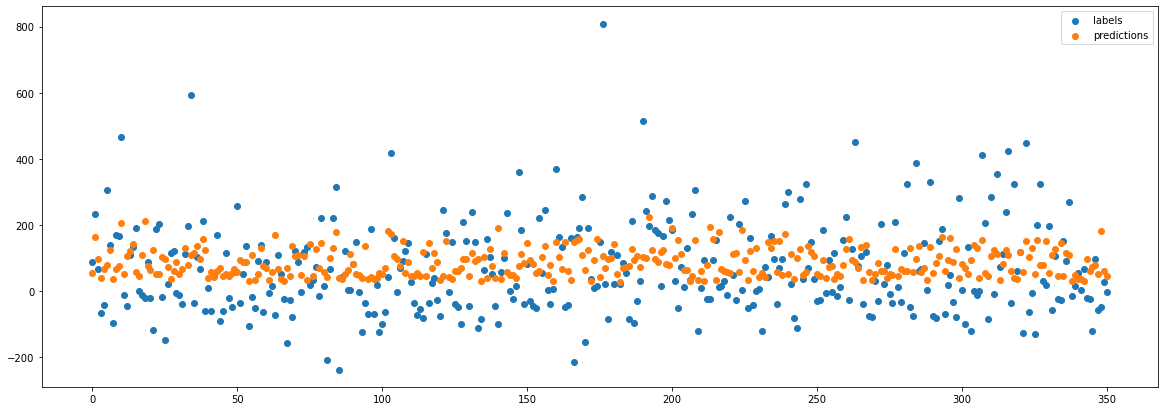

In [34]:
from matplotlib import pyplot as plt

# adjust these numbers to change the width and height of the plot!
plt.rcParams["figure.figsize"] = [20, 7]


def plot(r, l, preds, labels):
    assert len(preds) == len(labels)
    preds = preds[r:l]
    labels = labels[r:l]
    x = list(range(len(preds)))
    plt.scatter(x, labels, label="labels")
    plt.scatter(x, preds, label="predictions")
    plt.legend()
    plt.show()


plot(69, 420, preds, labels)